# Deep Convolutional Generative Adversarial Network

Code adapted from tensorflow tutorial with mnist images to AGN

### TODO:
1. Function to generate and save training set from trained generator
2. Or could use trained generator to generate images when required, instead of saving them all at once
6. Modify generator layers so images not dim at edges
8. Create slower gif / mp4
9. Try normalising images to 0-1 so 0s added in padding don't affect? (but tanh layer is -1 -> 1...)
10. Try different generator and discriminator architecture from article
11. Check discriminator output (should be 0-1 for loss functions to make sense?)
12. Plot gen and dis loss functions
13. Change generator to get rid of checkerboard artifacts


In [1]:
# Import required modules
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
print(tf.__version__)

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import rotate
from skimage.transform import resize
import os
import PIL
from tensorflow.keras import layers
from astropy import stats
import time
from IPython import display
import sys
from google.colab import drive

2.2.0-rc2


In [0]:
# Mount google drive to load the agn data set
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
## Load and pepare the dataset

# Load sigma clipped data
# train_images = np.load('/content/drive/My Drive/University of Birmingham/Year 4/Project/Data/Garon 2017/agn_data_clipped_indv.npy', allow_pickle=True)
# train_images = train_images[0]

train_images = np.load('/content/drive/My Drive/University of Birmingham/Year 4/Project/Data/Good/good_fr2.npy', allow_pickle=True)
num_images, size, _ = train_images.shape

sigma = 3
for i in range(num_images):
    _, median, std = stats.sigma_clipped_stats(train_images[i], sigma=sigma)
    train_images[i][train_images[i] < median+sigma*std] = 0

# Resize images to 56x56
train_images_resized = np.empty((num_images, 56, 56))
for i in range(num_images):
    train_images_resized[i] = resize(train_images[i], (56,56))
train_images = train_images_resized

# Normalise images to [-1,1]
for i in range(num_images):
    train_images[i] = 2*(train_images[i]-np.min(train_images[i]))/np.ptp(train_images[i])-1

# Augment images with rotations and flips
def augment_data(data,size):
    rotations = size//len(data) # rotations per image
    angles = np.linspace(0, 360, rotations)
    act_size = rotations*len(data)
    xpix, ypix = data.shape[1:]
    training_set = np.empty((act_size, xpix, ypix))
    for i in range(len(data)):
        for j in range(len(angles)):
            if j % 2 == 0: training_set[i*len(angles)+j,:,:] = rotate(np.fliplr(data[i,:,:]), angles[j], reshape=False, cval=-1)
            else: training_set[i*len(angles)+j,:,:] = rotate(data[i,:,:], angles[j], reshape=False, cval=-1)
    return training_set

# Augment images with rotations and flips
train_images = augment_data(train_images, 60000)

# Respahe data array to 4D, and type float32
train_images = train_images.reshape(train_images.shape[0], 56, 56, 1).astype('float32')

BUFFER_SIZE = len(train_images)
BATCH_SIZE = 256
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
## Create the generator and discriminator models

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 512)))
    assert model.output_shape == (None, 7, 7, 512) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 28, 28, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='sigmoid'))
    assert model.output_shape == (None, 56, 56, 1)

    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[56, 56, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [4]:
generator = make_generator_model()
discriminator = make_discriminator_model()

generator.summary()
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 25088)             2508800   
_________________________________________________________________
batch_normalization_4 (Batch (None, 25088)             100352    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 25088)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 512)         0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 7, 7, 256)         3276800   
_________________________________________________________________
batch_normalization_5 (Batch (None, 7, 7, 256)         1024      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 7, 7, 256)        

In [0]:
## New generator and discriminator models for testing

def make_generator_model1():
    # batch normalisation -> faster learning rate
    # too large first dense layer can lead to mode collapse
    model = tf.keras.Sequential()
    model.add(layers.Dense(14*14*1, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Reshape((14,14,1)))

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation=tf.nn.sigmoid))
    return model
    
def make_discriminator_model1():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[56, 56, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(128))
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(1, activation=tf.nn.sigmoid))

    return model

In [0]:
## Define the loss functions and optimizers for both models

# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
    
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
## Define the training loop

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [0]:
def train(dataset, epochs):
  start_time = time.time()
  start_epoch = int(epoch)

  image_save_loc = './images{}_{}'.format(start_epoch, start_epoch+epochs)
  if not os.path.isdir(image_save_loc): os.mkdir(image_save_loc)
  generate_and_save_images(generator, epoch, seed, image_save_loc)
  print('Starting from epoch {}'.format(start_epoch))

  train_g_loss_results, train_d_loss_results = [], []

  while epoch < start_epoch+epochs:
    epoch.assign_add(1)
    start = time.time()

    epoch_g_loss_avg, epoch_d_loss_avg = tf.keras.metrics.Mean(), tf.keras.metrics.Mean()

    for image_batch in dataset:
      batch_g_loss, batch_d_loss = train_step(image_batch)
      epoch_g_loss_avg(batch_g_loss)
      epoch_d_loss_avg(batch_d_loss)

    train_g_loss_results.append(epoch_g_loss_avg.result())
    train_d_loss_results.append(epoch_d_loss_avg.result())

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch, seed, image_save_loc)

    # Save the model every 50 epochs
    if (epoch) % 300 == 0:
      checkpoint_prefix = os.path.join(checkpoint_dir, "epoch{}".format(int(epoch)))
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {:.3f} sec'.format(int(epoch), time.time()-start))
    
  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed, image_save_loc)
  print('Total time for {} -> {} epochs was {:.3f} mins'.format(start_epoch, int(epoch), (time.time()-start_time)/60))

  return train_g_loss_results, train_d_loss_results
  
def generate_and_save_images(model, epoch, test_input, save_loc):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(16,4))

  for i in range(predictions.shape[0]):
      plt.subplot(2, 8, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='inferno')
      plt.axis('off')

  plt.savefig(save_loc+'/image_at_epoch_{:04d}.png'.format(int(epoch)))
  plt.show()

In [0]:
## Function to create and save training gif

def create_gif(save_loc, image_loc):
  # Use imageio to create an animated gif using the images saved during training.
  anim_file = save_loc+'{}-{}.gif'.format(int(epoch)-epochs,int(epoch))
  #anim_file = save_loc+'{}-{}.gif'.format(0,100)
  with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob(image_loc+'image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
      frame = 2*(i**0.5)
      if round(frame) > round(last):
        last = frame
      else:
        continue
      image = imageio.imread(filename)
      writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [0]:
## Setup test parameters and create save checkpoints

generator = make_generator_model()
discriminator = make_discriminator_model()
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

noise_dim = 100
num_examples_to_generate = 16
#np.random.seed(1)
#seed = np.random.normal(size=[num_examples_to_generate, noise_dim])
# seed and epoch need to be 'trackable' to save in checkpoint, e.g. tf.Variables
seed = tf.Variable(tf.random.normal([num_examples_to_generate, noise_dim]))
epoch = tf.Variable(0)

checkpoint_dir = './training_checkpoints'
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator,
                                 seed=seed,
                                 epoch=epoch)

#checkpoint_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)
#status = checkpoint.restore(checkpoint_dir+'/epoch500-10')

In [0]:
## Sanity checks
# Check normalisation of input images (rotation->0 padding matches background)
# Check Generator output normalisation
# Check discriminator output

In [0]:
# Delete directory
dir_loc = './images0_100/'
for f in os.listdir(dir_loc):
  os.remove(dir_loc+f)
os.rmdir(dir_loc)

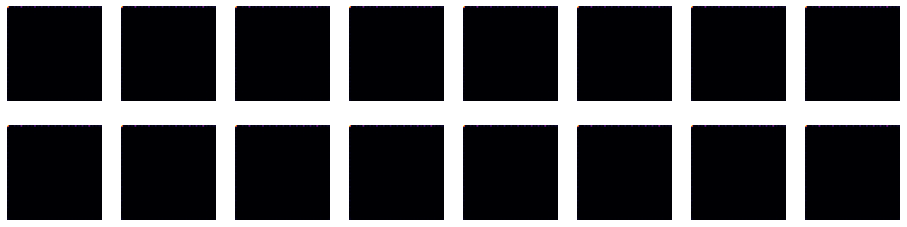

Time for epoch 21 is 24.142 sec


KeyboardInterrupt: ignored

In [0]:
## Train the model
epochs = 50
g_loss, d_loss = train(train_dataset, epochs)
save_loc = './'
anim_file = create_gif(save_loc, './images{}_{}/'.format(int(epoch)-epochs, int(epoch)))

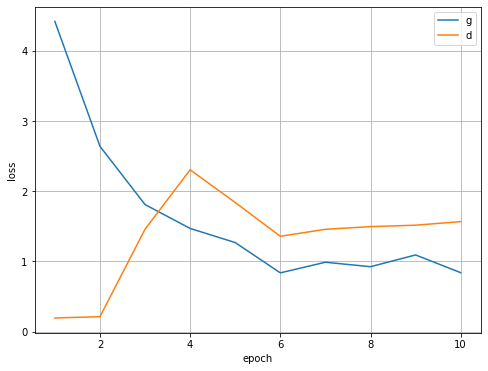

In [0]:
# Plot evolution of loss functions
fig = plt.figure(figsize=(8,6))
fig.patch.set_facecolor('w')
n = len(g_loss)
plt.plot(range(1,n+1),g_loss, label='g')
plt.plot(range(1,n+1),d_loss, label='d')
plt.legend()
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [0]:
save_loc = '/content/drive/My Drive/University of Birmingham/Year 4/Project/5. Code/GAN animations/test/'
anim_file = create_gif(save_loc, './images0_200/')

In [0]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  #image = imageio.imread(filename)
  #writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

## Generate training set from trained generator 


In [0]:
noise_input = tf.random.normal([10, noise_dim])
%timeit generator(noise_input)

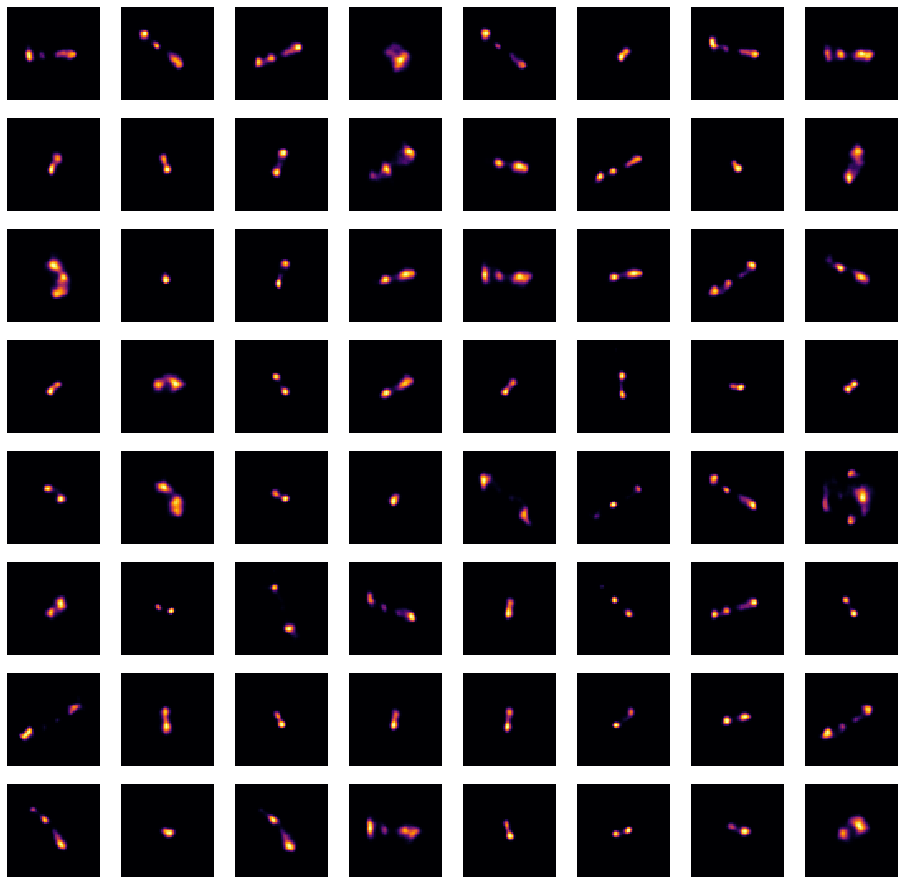

In [0]:
def generate_images(model, num):
  noise_input = tf.random.normal([num, noise_dim])
  # Notice `training` is set to False, so all layers run in inference mode (batchnorm).
  predictions = model(noise_input, training=False)
  n = predictions.shape[0]
  cols = 8
  rows = (n-1)//cols+1
  fig = plt.figure(figsize=(16,2*rows))
  for i in range(n):
      plt.subplot(rows, cols, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='inferno')
      plt.axis('off')
  plt.show()

generate_images(generator, 64)

In [0]:
# Test different methods to see which is fastest
# e.g. concatenate arrays, comute model in noise batches or indiviudally, etc.
def generate_array(model, num_batches):
  batch_size = 1000 # compute in batches so doesn't run out of memory
  predictions = np.empty((batch_size*num_batches,56,56,1))
  for batch in range(num_batches):
    noise_input = tf.random.normal([batch_size, noise_dim])
    predictions[batch*batch_size:batch*batch_size+batch_size] = model(noise_input, training=False)
  return predictions

gan_generated_images = generate_array(generator, 10)

In [0]:
gan_generated_images.shape
save_loc = '/content/drive/My Drive/University of Birmingham/Year 4/Project/5. Code/Data/'
np.save(save_loc, gan_generated_images)